In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# Set display option to show all columns
pd.set_option('display.max_columns', None)

# 1. Load Neccesary Data and Model

## 1.1 Load the XGBoost Voting Classifier

In [2]:
import pickle
import xgboost as xgb
from aml_model import XGBoostVotingClassifier
# Load the model from the file
with open("xgboost_voter_model.pkl", "rb") as f:
    xgboost_voter = pickle.load(f)

## 1.2 Load Model Feature Columns

In [3]:
# select a few transaction features and top 15 important features from xgboost_voter for retraining
import pickle

# Load the feature list from the file
with open("selected_columns.pkl", "rb") as f:
    selected_columns = pickle.load(f)

## 1.3 Load the Test Dataframe

In [4]:
test_df = pd.read_feather('test.feather')

In [5]:
print(f"Number of Testing samples: {len(test_df)}")

Number of Testing samples: 2851456


## 1.4 Load the LIME Explainer

In [6]:
import dill
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function
np.random.seed(1)

# Load the model from the file
file_path = "lime_explainer.pkl"
with open(file_path, "rb") as f:
    lime_explainer = dill.load(f)

## 1.5 Load the graph

In [7]:
import pickle

# Load the graph from the pickle file
with open("launder_graph.pickle", "rb") as f:
    launder_graph = pickle.load(f)

## 1.6 Define neccesary functions

In [28]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_subgraph(account_node, ego_subgraph, title, filename="Counterparties.png"):
    plt.figure(figsize=(10, 7))
    
    plt.title(title)
    
    # Define positions
    pos = {}
    node_size = 500
    
    # Set position for account node (middle)
    pos[account_node] = (0, 0)

    # Set positions for out-degree nodes (right)
    out_degree_nodes = [node for node in ego_subgraph.nodes() if node != account_node and ego_subgraph.out_degree(node) > 0]
    num_out_degree = len(out_degree_nodes)
    for i, node in enumerate(out_degree_nodes):
        pos[node] = (1, (i - (num_out_degree-1)/2) * 0.1)
    
    # Set positions for in-degree nodes (left)
    in_degree_nodes = [node for node in ego_subgraph.nodes() if node != account_node and ego_subgraph.in_degree(node) > 0]
    num_in_degree = len(in_degree_nodes)
    for i, node in enumerate(in_degree_nodes):
        pos[node] = (-1, (i - (num_in_degree-1)/2) * 0.1)
    
    
    
    # Draw the egonet subgraph
    nx.draw(ego_subgraph, pos, with_labels=True, node_size=node_size, node_color='skyblue', font_size=8)
    
    # Highlight the target node
    nx.draw_networkx_nodes(ego_subgraph, pos, nodelist=[account_node], node_size=node_size, node_color='purple')
    plt.tight_layout()
    plt.savefig(filename)

# Example usage
# plot_subgraph(account_node, ego_subgraph, title)


In [10]:
def get_ego_graph(graph, target_node):
    # Get neighbors in the first hop
    first_hop_neighbors = set(nx.all_neighbors(graph, target_node))
    
    # Get neighbors in the subsequent hops up to the specified radius
    neighbors = set(first_hop_neighbors).union({target_node})
    subgraph = graph.subgraph(neighbors)
    return subgraph

# 2. Develop Explaination Module

## 2.1 Randomly Select Suspicious Transaction from Testing Dataframe

In [11]:
trans_df = pd.read_feather('trans_df.feather')

In [12]:
trans_df = trans_df[['Transaction_id', 'Hour',
       'Minute', 'Date', 'Year', 'Month', 'Day', 'Sender_account',
       'Receiver_account', 'Amount', 'Amount_USD', 'Payment_currency',
       'Received_currency', 'Sender_bank_location', 'Receiver_bank_location',
       'Payment_type']]

In [13]:
mask = test_df['Is_laundering'] == 1
testing_transactions_id = test_df[mask]['Transaction_id'].to_list()

In [14]:
import pandas as pd

def create_table(df):
    # Transpose the DataFrame to swap rows and columns
    transposed_df = df.transpose()
    
    # Rename the index to 'Column_Name'
    transposed_df.index.name = 'Column_Name'
    
    # Reset the index to make 'Column_Name' a regular column
    transposed_df.reset_index(inplace=True)
    
    # Rename the column containing the row values to 'Column_Value'
    transposed_df.columns = ['Column_Name', 'Column_Value']
    
    return transposed_df

# Create a function to get transaction information
def get_trans_info_and_trans_features(info_df, feat_df, choice, transaction_id_list, selected_columns):
    
    if choice == "random":
        trans_id = np.random.choice(transaction_id_list)
        
        mask1 =info_df['Transaction_id'] == trans_id

        transaction_info = info_df[mask1]
        
        mask2 = feat_df['Transaction_id'] == trans_id

        transaction_features = feat_df[mask2]
        
        return create_table(transaction_info), create_table(transaction_features[selected_columns])
        
    else:
        print(f"These are the suspicious transaction list: {transaction_id_list}")
        
        trans_id = input('Enter the Transaction ID: ')
        
        mask1 = info_df['Transaction_id'] == trans_id

        transaction_info = info_df[mask1]
        
        mask2 = feat_df['Transaction_id'] == trans_id

        transaction_features = feat_df[mask2]
        
        return create_table(transaction_info), create_table(transaction_features[selected_columns])
        
transaction_info, transaction_features = get_trans_info_and_trans_features(info_df=trans_df, feat_df=test_df,
                                                                           choice="random", transaction_id_list=testing_transactions_id,
                                                                           selected_columns=selected_columns)


In [15]:
test_transaction = transaction_features['Column_Value'].values

In [22]:
num_features = 5
exp = lime_explainer.explain_instance(test_transaction, xgboost_voter.predict_proba, num_features=num_features)
#exp.show_in_notebook(show_table=True, show_all=True)

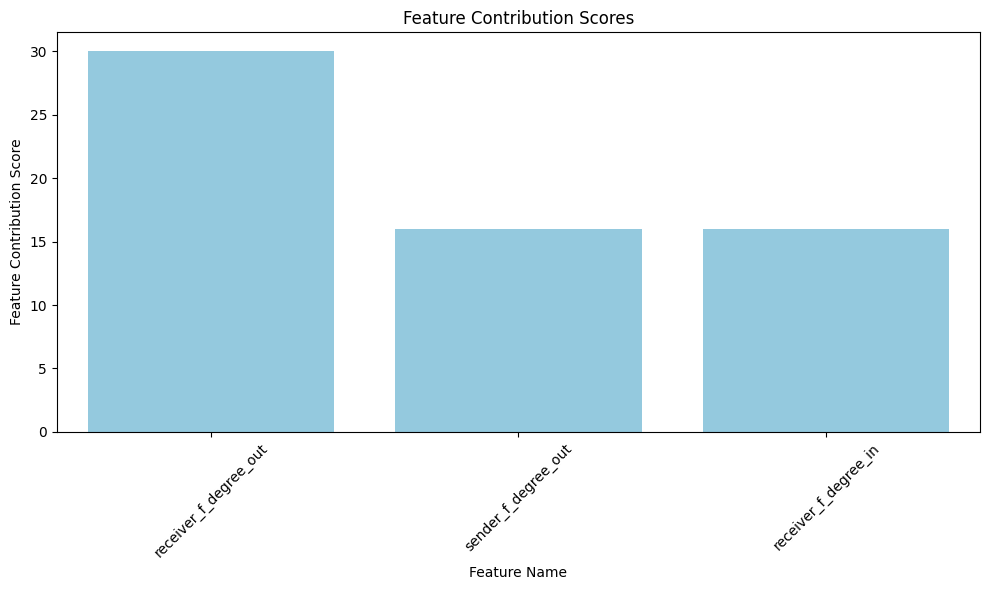

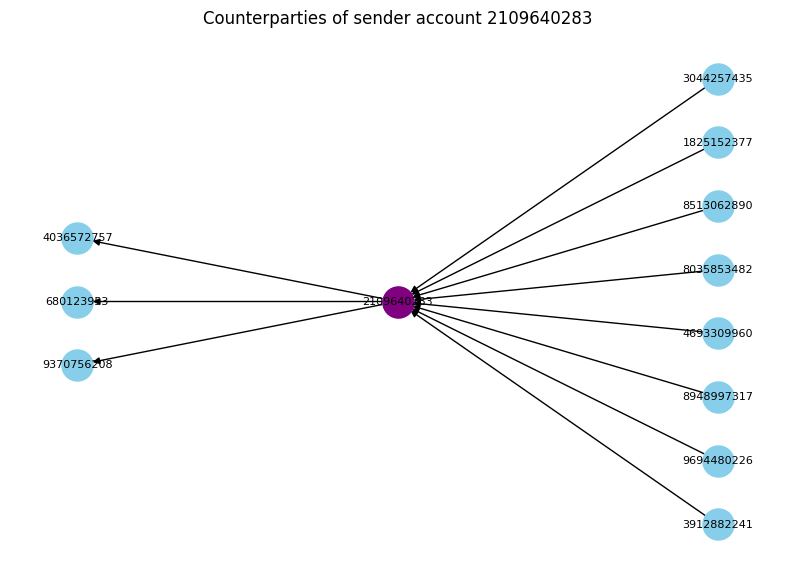

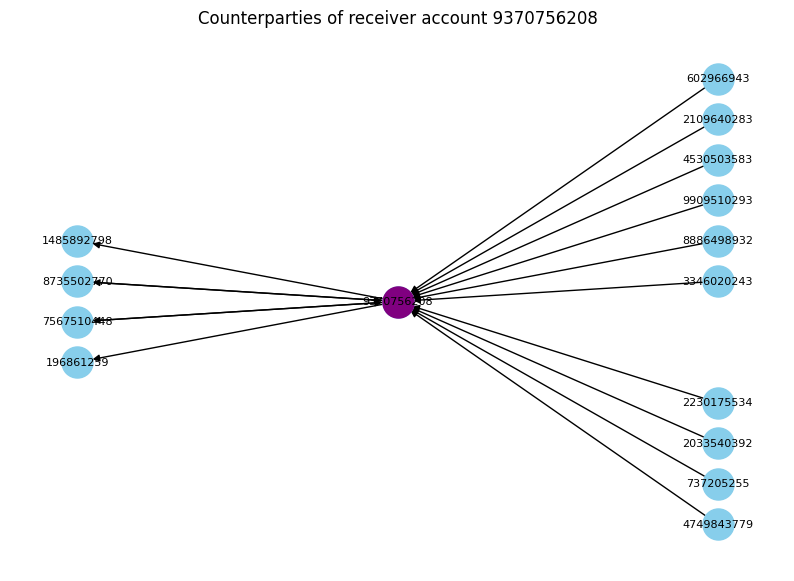

In [23]:
condition_boundaries_dict = {
    'feature_name':[],
    'feature_value':[],
    'feature_contribution_score':[]
}

for column_index, feature_importance_score in exp.as_map()[1]:
    feature_name = transaction_features.iloc[column_index]['Column_Name']
    
    feature_value = transaction_features.iloc[column_index]['Column_Value']
    
    feature_importance_score = np.round(feature_importance_score * 100)
    
    if feature_importance_score > 0:
        condition_boundaries_dict['feature_name'].append(feature_name)

        condition_boundaries_dict['feature_value'].append(feature_value)
        
        condition_boundaries_dict['feature_contribution_score'].append(feature_importance_score)

contribution_df = pd.DataFrame(condition_boundaries_dict)
# Sort the dataframe by feature_importance_score
contribution_df = contribution_df.sort_values(by='feature_contribution_score', ascending=False)

#============================================================================================================
# PART 1: Show Graph
#============================================================================================================
import matplotlib.pyplot as plt
import seaborn as sns

def create_feature_contribution_pic(contribution_df, filename):
    # Create the horizontal bar plot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.barplot(y='feature_contribution_score', x='feature_name', data=contribution_df, color='skyblue')
    
    # Add titles and labels
    plt.title('Feature Contribution Scores')
    plt.xlabel('Feature Name')
    plt.ylabel('Feature Contribution Score')
    plt.xticks(rotation=45)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(filename)


# Example usage:
feature_importance_scores = contribution_df['feature_contribution_score'].to_list()
model_name = "XGBoost Voter Model"
sender_account = transaction_info[transaction_info['Column_Name'] == 'Sender_account']['Column_Value'].values[0]
receiver_account = transaction_info[transaction_info['Column_Name'] == 'Receiver_account']['Column_Value'].values[0]
create_feature_contribution_pic(contribution_df, filename="feature_contribution.png")

ego_subgraph = get_ego_graph(launder_graph, sender_account)
plot_subgraph(sender_account, ego_subgraph, title=f"Counterparties of sender account {sender_account}", filename="sender_counterparties.png")

ego_subgraph = get_ego_graph(launder_graph, receiver_account)
plot_subgraph(receiver_account, ego_subgraph, title=f"Counterparties of receiver account {receiver_account}",  filename="receiver_counterparties.png")

# 2.2 Produce PDF File

In [31]:
from docx import Document
from docx.shared import Inches
from docx2pdf import convert

def create_table_with_spacing(transaction_info, document):
    # Create a table with the appropriate number of rows and columns
    table = document.add_table(rows=1, cols=transaction_info.shape[1])

    # Set table style to 'Table Grid'
    table.style = 'Table Grid'

    # Set the table borders to a darker color and add spacing
    for row in table.rows:
        for cell in row.cells:
            cell.paragraphs[0].paragraph_format.space_after = Pt(6)  # Adjust spacing as needed
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.color.rgb = (0x00, 0x00, 0x00)  # Setting font color to black

    # Add column headers to the table
    hdr_cells = table.rows[0].cells
    for i, col in enumerate(transaction_info.columns):
        hdr_cells[i].text = col

    # Add data rows to the table
    for _, row in transaction_info.iterrows():
        row_cells = table.add_row().cells
        for i, value in enumerate(row):
            row_cells[i].text = str(value)

def create_table_with_dark_lines(transaction_info, document):
    # Create a table with the appropriate number of rows and columns
    table = document.add_table(rows=1, cols=transaction_info.shape[1])

    # Set table style to 'Table Grid'
    table.style = 'Table Grid'

    # Set the table borders to a darker color
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.color.rgb = (0x00, 0x00, 0x00)  # Setting font color to black

    # Add column headers to the table
    hdr_cells = table.rows[0].cells
    for i, col in enumerate(transaction_info.columns):
        hdr_cells[i].text = col

    # Add data rows to the table
    for _, row in transaction_info.iterrows():
        row_cells = table.add_row().cells
        for i, value in enumerate(row):
            row_cells[i].text = str(value)

def generate_aml_report(docx_file, contribution_df, feature_importance_scores, model_name, transaction_features, transaction_info,
                        sender_account, receiver_account):
    """
    Generate an explanation docx report for AML compliance officers based on features names and feature importance scores.

    Parameters:

    Returns:
    None:.
    """
    #=======================================================================================================
    # Intro Prompt
    #=======================================================================================================

    document = Document()

    document.add_heading('Suspicious Transaction Alert', 0)
    
    explanation = "Dear AML Compliance Officer,\n\n"
    explanation += f"The transaction between sender_account {sender_account}\
 and receiver_account {receiver_account} has been flagged as "
    p = document.add_paragraph(explanation)
    explanation = " Details will be listed in PART A (Transaction Information), PART B (Transaction Features),\
 PART C (Counterparties Screenshot), and PART D (Model Justification)."
    p.add_run('suspicious.').bold = True
    p.add_run(explanation)

    

    #=======================================================================================================
    # PART A (Transaction Information) Prompt
    #=======================================================================================================

    explanation = "PART A (Transaction Information)"
    document.add_heading(explanation, level=1)
    
    explanation = "Transaction Information Table"
    p = document.add_paragraph(explanation)

    create_table_with_dark_lines(transaction_info, document)

    #=======================================================================================================
    # PART B (Transaction Features) Prompt
    #=======================================================================================================

    explanation = "PART B (Transaction Features)"
    document.add_heading(explanation, level=1)
    
    explanation = "Transaction Features Table"
    p = document.add_paragraph(explanation)

    create_table_with_dark_lines(transaction_features, document)

    #=======================================================================================================
    # PART C (Counterparties Screenshot) Prompt
    #=======================================================================================================

    explanation = "PART C (Counterparties Screenshot)"
    document.add_heading(explanation, level=1)
    
    explanation = f"Counterparties Screenshot of Sender account {sender_account}"
    p = document.add_paragraph(explanation)

    p = document.add_paragraph("\n")
    document.add_picture('sender_counterparties.png', width=Inches(6.5))

    explanation = f"Counterparties Screenshot of receiver account {receiver_account}"
    p = document.add_paragraph(explanation)

    p = document.add_paragraph("\n")
    document.add_picture('receiver_counterparties.png', width=Inches(6.5))
    
    #=======================================================================================================
    # PART D (Model Justification) Prompt
    #=======================================================================================================

    explanation = "PART C (Model Justification)"
    document.add_heading(explanation, level=1)
    
    explanation = "Feature Contribution Score Table"
    p = document.add_paragraph(explanation)

    create_table_with_dark_lines(contribution_df, document)
            
    p = document.add_paragraph("\n")
    document.add_picture('feature_contribution.png', width=Inches(6))
                               
    explanation = "Explanation:\n\
The A.I. identified the above features as significant for predicting suspicious transactions, based on their contribution scores.\
 Higher scores indicate greater influence on the prediction outcome. "
    explanation += "\n"
    p = document.add_paragraph(explanation)

    #=======================================================================================================
    # Ending Prompt
    #=======================================================================================================
    explanation = "\nThe combinination of these conditions raises concerns about the transaction's nature. Further investigation is warranted to ensure compliance with anti-money laundering regulations.\n\n"
    explanation += "Please let me know if you require any further information or assistance regarding this matter.\n\n"
    explanation += "Sincerely,\n[Python Developer]"
    
    p = document.add_paragraph(explanation)

    
    # Generate docx file
    document.add_page_break()

    document.save(docx_file)

    # Convert DOCX to PDF
    convert(docx_file)


# Called the function
docx_file = "Suspicious_Transaction_Alert.docx"
generate_aml_report(docx_file, contribution_df, feature_importance_scores, 
                    model_name, transaction_features, transaction_info,
                    sender_account, receiver_account)    


  0%|          | 0/1 [00:00<?, ?it/s]